### Code

In [17]:
from covariance import logPr, logX_model, logX_mean, cov_inv_at_iteration


def live_cg(samples, iteration):
    logL = np.array(samples.live_points(iteration).logL)
    mean = logX_mean(samples, iteration)
    cov_inv = cov_inv_at_iteration(samples, iteration)
    return logL, mean, cov_inv


def logPr_params(samples, iteration, params):
    logLmax, d, sigma = params
    from covariance import logPr, logX_model
    logL, mean, cov_inv = live_cg(samples, iteration)
    logX = logX_model(logL, logLmax, d, sigma)
    logPr_params = logPr(logX, mean, cov_inv)
    return logPr_params

### Implementation
`covariance.py` contains the necessary functions for this approach  
`logX_mean(samples, iteration)`
returns vector $\bm{\mu}$ at iteration $k$\, where $\bm{\mu}$ is the expected value of $X$ at the iterations where the current live points die
$$\bm{\mu}=(E[\log X_\text{live}^{(1)}],  \cdots, E[\log X_\text{live}^{(n_k)}])$$

`cov_inv_at_iteration(samples, iteration)` returns the covariance matrix between the areas of the $n_k$ live points; sum from first iteration to iteration $i/j$. Cholesky decomposition requires all iterations rather than just those sampled, here inefficient when analytical solution for the covariance is known.
$$
\bm{\Sigma}(\log X_i, \log X_j) = \sum_{l=1}^{\min(i, j)} \frac{1}{{n_l}^2}
$$

`logX_model(logL, logLmax, d, sigma)` returns $\log \bm{X}$ as a function of $\log L$ and the parameters. $\log L_{\text{max}}$ is a constant array of same dimension as $\log \bm{L}$
$$
\log \bm{X} = \frac{d}{2} \log [2\sigma^2 (\log \bm{L_{\text{max}}} - \log \bm{L})]
$$

`logPr(logX, mean, cov_inv)` returns probability of getting $\log X$, given their expected values and covariance - this is what we want to optimise
$$
\log \Pr = - \frac{1}{2} (\log \bm{X} - \bm{\mu}) \Sigma^{-1} (\log \bm{X} - \bm{\mu})
$$

`optimise_pr_cg(logL, mean, cov_inv, x0)` returns the estimated solution for the parameters, by optimising $\log \Pr$ starting from an initial guess `x0`

`params_at_iteration_cg(samples, iteration)` wraps all of the above together; returns the correlated gaussian estimate of the parameters at a given iteration. The initial guess `x0` is provided by the result from `partial_lm`

### Estimate for $d$ using CG model is low
- 2D plot of likelihood function in terms of $\log L_{\text{max}}, d, \sigma$ to visualise/check that the global minimum is found

Show results; run model for variety of samples and iterations, make plots

Possible points of failure
1. Construction of inverse covariance; print $\Sigma$ and $\Sigma^{-1}$
2. Construction of mean vector; print $\mu$
3. Minimization procedure; show that global minimum is found, try to reproduce multiplication problem
- Speed-up covariance matrix inversion by solving analytically

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load test samples
from tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("test_samples/samples_1.pickle")
#samples_g_2, samples_c_2, samples_w_2 = pickle_in("test_samples/samples_low_var.pickle")
#samples_g_3, samples_c_3, samples_w_3 = pickle_in("test_samples/samples_high_dim.pickle")

In [26]:
from covariance import params_at_iteration_cg, cov_inv_at_iteration, logX_mean
from tools import params_at_iterations
from plotting import plot_estimates, plot_fit_at_iteration

### Results

Iteration 1000 complete
Iteration 3000 complete
Iteration 5000 complete
Iteration 7000 complete
Iteration 9000 complete
Iteration 11000 complete
Iteration 13000 complete
Iteration 15000 complete
Iteration 17000 complete
Iteration 19000 complete


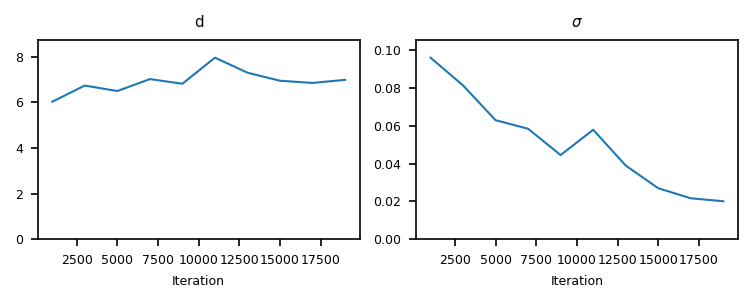

In [20]:
# samples_g_1
iterations = np.arange(1000,20000,2000)
estimates = params_at_iterations(samples_g_1, iterations, params_at_iteration_cg)
plot_estimates(iterations, estimates[:,1], estimates[:,2], figsize=(5,2), dpi=150)

Iteration 1000 complete
Iteration 3000 complete
Iteration 5000 complete
Iteration 7000 complete
Iteration 9000 complete
Iteration 11000 complete
Iteration 13000 complete
Iteration 15000 complete
Iteration 17000 complete
Iteration 19000 complete


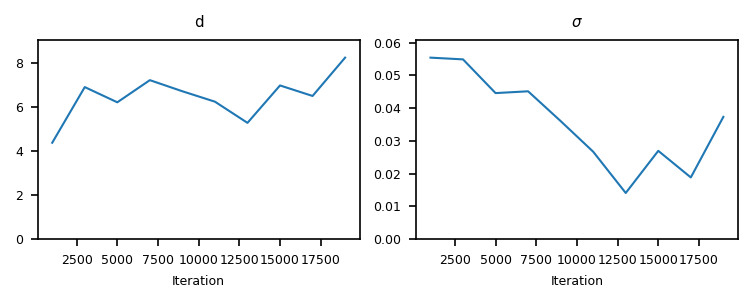

In [21]:
# samples_c_1
iterations = np.arange(1000,20000,2000)
estimates = params_at_iterations(samples_c_1, iterations, params_at_iteration_cg)
plot_estimates(iterations, estimates[:,1], estimates[:,2], figsize=(5,2), dpi=150)

In [7]:
# samples_w_1
# iterations = np.arange(1000,8000,500)
# estimates = params_at_iterations(samples_w_1, iterations, params_at_iteration_cg)
# plot_estimates(iterations, estimates[:,1], estimates[:,2], figsize=(5,2), dpi=150)

### 1. Construction of inverse covariance

In [22]:
# Print covariance matrix
np.linalg.inv(cov_inv_at_iteration(samples_c_1, 1000))

array([[0.001001, 0.001001, 0.001001, ..., 0.001001, 0.001001, 0.001001],
       [0.001001, 0.001002, 0.001002, ..., 0.001002, 0.001002, 0.001002],
       [0.001001, 0.001002, 0.001003, ..., 0.001003, 0.001003, 0.001003],
       ...,
       [0.001001, 0.001002, 0.001003, ..., 0.004319, 0.004319, 0.004319],
       [0.001001, 0.001002, 0.001003, ..., 0.004319, 0.004631, 0.004631],
       [0.001001, 0.001002, 0.001003, ..., 0.004319, 0.004631, 0.005239]])

In [23]:
# Inverse covariance matrix
cov_inv_at_iteration(samples_c_1, 1000)

array([[ 1.00099900e+06, -1.00000000e+06,  1.36957112e-11, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.00000000e+06,  2.00000000e+06, -1.00000000e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.00000000e+06,  2.00000000e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.57051282e+04, -3.20512821e+03,  4.11727845e-11],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.20512821e+03,  4.84986505e+03, -1.64473684e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.15494053e-11, -1.64473684e+03,  1.64473684e+03]])

### 2. Construction of mean vector

In [10]:
logX_mean(samples_c_1, 1000)

array([-1.40250578, -1.40378865, -1.40507317, -1.40635935, -1.40764718,
       -1.40893667, -1.41022782, -1.41152065, -1.41281515, -1.41411132,
       -1.41540918, -1.41670873, -1.41800996, -1.41931289, -1.42061753,
       -1.42192386, -1.42323191, -1.42454166, -1.42585314, -1.42716634,
       -1.42848126, -1.42979792, -1.43111631, -1.43243644, -1.43375832,
       -1.43508195, -1.43640733, -1.43773447, -1.43906337, -1.44039404,
       -1.44172649, -1.44306071, -1.44439672, -1.44573451, -1.4470741 ,
       -1.44841548, -1.44975866, -1.45110365, -1.45245045, -1.45379907,
       -1.45514951, -1.45650178, -1.45785587, -1.4592118 , -1.46056958,
       -1.4619292 , -1.46329067, -1.46465399, -1.46601918, -1.46738624,
       -1.46875516, -1.47012596, -1.47149865, -1.47287322, -1.47424968,
       -1.47562804, -1.4770083 , -1.47839047, -1.47977456, -1.48116056,
       -1.48254848, -1.48393834, -1.48533013, -1.48672386, -1.48811953,
       -1.48951715, -1.49091673, -1.49231828, -1.49372178, -1.49

### 3. Minimization procedure

#### Check global minimum obtained

In [5]:
# Optimal params for CG and LS minimization
from lm_partial import analytic_lm_params
samples = samples_g_1
iteration = 1000
optimized_params_cg = params_at_iteration_cg(samples, iteration)
optimized_params_ls = analytic_lm_params(samples, iteration)
print(f"cg: {optimized_params_cg} \nls: {optimized_params_ls}")

cg: [-5.03521668  6.03056209  0.09618764] 
ls: [-0.013429920412210805, 9.9043502643925, 0.10086559035436087]


<AxesSubplot: >

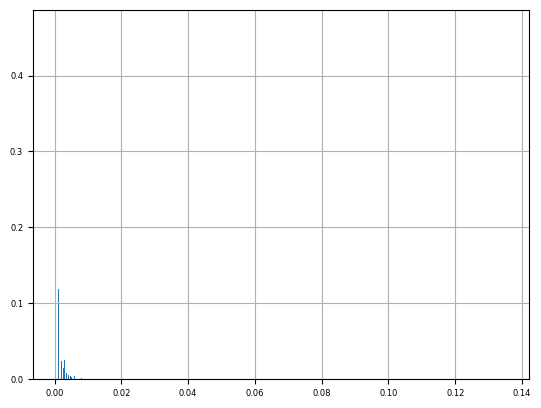

In [20]:
indices = samples_g_1.live_points(iteration).index
logX_mean = samples_g_1.logX()[indices]
np.exp(logX_mean).hist(bins=1000)

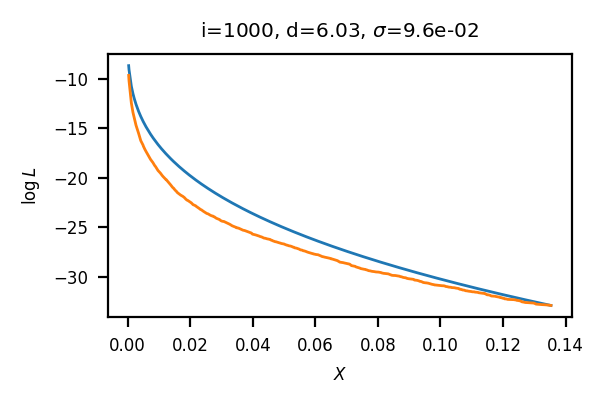

In [8]:
plot_fit_at_iteration(samples, iteration, optimized_params_cg, figsize=(3,2))

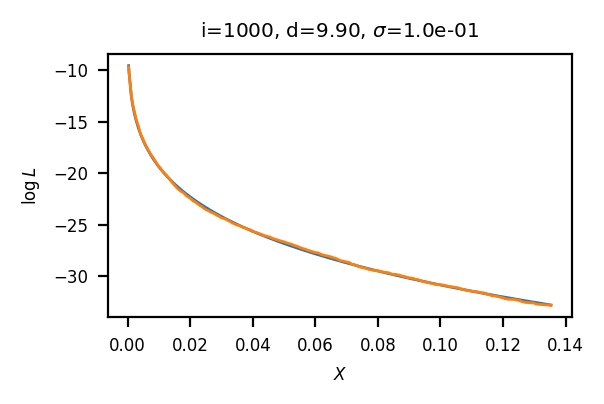

In [9]:
plot_fit_iteration(samples, iteration, optimized_params_ls, figsize=(3,2))

In [26]:
# logPr at those params
logPr_ls = logPr_params(samples_g_1, 1000, optimized_params_ls)
logPr_cg = logPr_params(samples_g_1, 1000, optimized_params_cg)
print(f"cg: {logPr_cg}\nls: {logPr_ls}")

cg: -359.3443278743497
ls: -499.68773370644084


#### **Contour plot**

In [27]:
NL, Nd, Ns = 10, 20, 10
logLmaxs = np.linspace(-10, -1, NL)
ds = np.linspace(5, 15, Nd)
sigmas = np.linspace(0.05, 0.15, Ns)

In [ ]:
# Calculate logPr for whole range of params
logPrs = np.zeros((NL, Nd, Ns))
for i in range(NL):
    for j in range(Nd):
        for k in range(Ns):
            logPrs[i][j][k] = logPr_params(samples, iteration, [logLmaxs[i], ds[j], sigmas[k]])
            print(i, j, k)

In [28]:
from tools import pickle_in
logPrs = pickle_in("logPrs_sg1.pickle")
dv, sigmav = np.meshgrid(ds, sigmas)

In [29]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(logLmax=widgets.IntSlider(min=-8, max=-1, step=1))
def plot_contour(logLmax):
    i = int(logLmaxs[logLmax+10])
    contour_range = np.array(list(np.linspace(-10000, -2000, 50, endpoint=False)) + list(np.linspace(-2000, logPrs[i].max(), 15)))
    #plt.contour(dv, sigmav, logPrs[i].T, contour_range);
    plt.xlabel("d")
    plt.ylabel("$\sigma$")
    (d_max_index, sigma_max_index), max_val = np.unravel_index(logPrs[i].argmax(), logPrs[i].shape), logPrs[i].max()
    plt.text(ds[d_max_index], sigmas[sigma_max_index], f"{max_val:.1f}")

interactive(children=(IntSlider(value=-1, description='logLmax', max=-1, min=-8), Output()), _dom_classes=('wi…